<a href="https://colab.research.google.com/github/eriosta/neuro/blob/main/Optimizing_Component_Selection_for_Enhanced_Correlation_Analysis_in_fMRI_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **_Synopsis_**
To address the challenge of determining the optimal number of components to generate using ICA/DL, we developed a program that:
1. Performs DL to produce both low- and high-order decomposition components.
2. Iterates through every component in both low- and high-order sets, identifying the peak voxel coordinates. This peak voxel (the voxel with the highest activity) serves as a simplified "location pin" for each component within the brain.
3. Assesses the spatial relationship between components by measuring the Euclidean distance between their respective peak voxels. Components are considered anatomically proximal (i.e., potentially within the same brain region) if their distance is less than a predetermined threshold.
4. For components that are anatomically near each other, conducts Pearson correlation to pinpoint those that are both anatomically and functionally similar.
5. Sums up the Pearson correlation coefficients (statistically significant at p<0.05 by default) for each combination. The combination boasting the highest magnitude in its total sum is identified as having the most similarly activating functional networks in roughly the same anatomical location. This indicates the optimal min-max range (from low-order to high-order) of component numbers for the best decomposition.

A few challenges remain. The anatomical location between components that are "near" is not perfect, which is expected by using a singular peak voxel to get the general coordinates of the network. Also, this is a computational costly program, especially as we compare wider ranges of low- vs. high-order components (e.g., 20 vs. 100 took a couple of hours)

# Component Analysis of Resting-State fMRI Data

## Decomposition of Data
The functional magnetic resonance imaging (fMRI) data is subjected to a specialized decomposition process. This process aims to uncover the underlying spatial patterns, known as 'components', embedded within the data. The extracted components can further provide insights into neural activations and their spatial relationships.

### Low-Order and High-Order Components
A unique aspect of our investigation involves categorizing the extracted components into two distinct groups: 'low-order' and 'high-order'. These classifications are essential to understanding the hierarchical relationships and functional connectivity within the data.

## Peak Voxel Identification and Analysis
* **Peak Voxel Definition**: Within each component, a voxel with the highest activity is termed as the 'peak voxel'. Identifying these peak voxels provides key insights into regions of most pronounced neural activation.
* **Peak Voxel Coordinates**: The spatial coordinates of the peak voxels are determined for detailed analysis.

## Anatomical Proximity and Overlap Analysis
* **Distance Measurement**: The spatial relationship between components is measured by calculating the Euclidean distance between their corresponding peak voxels.
* **Proximity Thresholding**: By applying a predetermined distance threshold, we identify pairs of components from the low-order and high-order groups that are anatomically proximate. This thresholded analysis guides further investigation into the intricate spatial relationships existing within the fMRI data.


# Pearson Correlation of Anatomically Proximal Components

## Selection Criteria for Component Pairing
* **Dual-Level Correlation Analysis**: For every component in the low-order group, a systematic correlation assessment with each high-order component is undertaken.
* **Anatomical Proximity Filtering**: Prior to the correlation computation, an essential criterion is established based on the anatomical proximity of their peak voxels. Component pairs failing this spatial proximity check are disregarded in subsequent analyses.

## Filter Statistically Significant Correlations
* **Correlation Significance**: Post-correlation computation, we subject the results to rigorous statistical validation to ascertain their significance.
* **Significance Threshold**: Correlations are meticulously filtered, with only those exhibiting significance levels below a predetermined alpha value being retained for further investigation.

## Efficient Computation through Parallelization
* **Need for Speed**: Given the computationally intensive nature of our analyses, we've employed advanced computational strategies.
* **Distributed Processing**: By leveraging parallel processing techniques, we distribute the correlation computation tasks across multiple processing units. This parallelization ensures a more efficient and timely execution of calculations.


In [1]:
!pip install -q nilearn
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.decomposition import DictLearning
from nilearn import plotting, image
from scipy.stats import pearsonr
from nilearn import datasets, image
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 19.7 MB/s eta 0:00:00


## Grid Search for Optimal N Components by Anatomic Proximity

In [ ]:
# @title ComponentCorrelationCalculator class

import numpy as np
import warnings
import time
import concurrent.futures
from tqdm import tqdm
from nilearn import datasets
from nilearn.decomposition import DictLearning
from scipy.stats import pearsonr
from scipy import stats
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

class ComponentCorrelationCalculator:
    """Calculate and analyze the correlation between components of fMRI data."""

    def __init__(self, n_low_order, n_high_order, func_filenames, alpha=0.05, distance_threshold=5):
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order
        self.func_filenames = func_filenames
        self.alpha = alpha
        self.distance_threshold = distance_threshold

    def _get_peak_coordinates(self, component):
        """Get the coordinates of the peak (maximum value) of the component."""
        max_val_index = np.unravel_index(np.argmax(component), component.shape)
        return max_val_index

    def _anatomical_overlap(self, comp1, comp2):
        """Check if two components have peaks in a proximal location."""
        peak1 = self._get_peak_coordinates(comp1)
        peak2 = self._get_peak_coordinates(comp2)

        distance = np.linalg.norm(np.array(peak1) - np.array(peak2))

        return distance < self.distance_threshold

    def _decompose(self, n_components):
        dict_learn = DictLearning(n_components=n_components, random_state=0)
        return dict_learn.fit_transform(self.func_filenames)

    def perform_decomposition(self):
        self.components_img_low = self._decompose(self.n_low_order)
        self.components_img_high = self._decompose(self.n_high_order)

    def compute_correlation_matrix(self):
        matrix = np.zeros((self.n_low_order, self.n_high_order))

        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]

                if not self._anatomical_overlap(data_low, data_high):
                    continue

                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())

                if p_value < self.alpha:
                    matrix[i, j] = correlation

        return np.nan_to_num(matrix)

    def calculate_component_correlation(self):
        self.perform_decomposition()
        correlation_matrix = self.compute_correlation_matrix()
        positive_r = correlation_matrix[correlation_matrix > 0].sum()
        return self.n_low_order, self.n_high_order, positive_r

def optimize_components(n_low_range, n_high_range, func_filenames, alpha, distance_threshold):
    best_values = {"n_low": None, "n_high": None, "cumulative_r": -np.inf}
    results = []

    valid_combinations = [(n_low, n_high) for n_low in n_low_range for n_high in n_high_range if n_high > n_low]
    total_combinations = len(valid_combinations)

    # Suppress constant input warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=stats.ConstantInputWarning)

        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [executor.submit(ComponentCorrelationCalculator(n_low, n_high, func_filenames, alpha, distance_threshold).calculate_component_correlation) for n_low, n_high in valid_combinations]

            progress_bar = tqdm(total=total_combinations, desc="Calculating Correlations", ncols=100)  # Initialize the tqdm progress bar

            start_time = time.time()
            for future in concurrent.futures.as_completed(futures):
                n_low, n_high, positive_r = future.result()
                results.append((f"{n_low}_{n_high}", positive_r))
                if positive_r > best_values["cumulative_r"]:
                    best_values = {"n_low": n_low, "n_high": n_high, "cumulative_r": positive_r}

                progress_bar.update(1)  # Manually update the tqdm progress bar

            elapsed_time = time.time() - start_time
            avg_time_per_combination = elapsed_time / total_combinations

            progress_bar.close()  # Close the tqdm progress bar

            print(f"\nAverage time per combination: {avg_time_per_combination:.2f}s")
            print(f"Estimated total time: {elapsed_time:.2f}s")

    return best_values, results

def plot_results(results, best_combo, min_value, max_value):
    labels, values = zip(*results)
    max_value_result = max(values)
    max_idx = values.index(max_value_result)

    number_of_combinations = max_value - min_value + 1
    fig_width = 5 + number_of_combinations // 10

    plt.figure(figsize=(fig_width, 5))
    bars = plt.bar(labels, values, color='lightblue')
    bars[max_idx].set_color('lightcoral')
    plt.xticks(rotation=90)
    plt.annotate('★', (max_idx, max_value_result + 0.1), ha='center', color='black', fontsize=15)
    plt.ylabel('Cumulative r')
    plt.title(f'Most optimal combination is between: {best_combo}')
    plt.tight_layout()
    plt.show()


Enter the minimum value for the range: 5
Enter the maximum value for the range: 20
Enter the significance level (default is 0.05): 0.05

The anatomical overlap threshold determines how close the peak voxels of two components should be to consider them as overlapping. A smaller value means they must be very close, while a larger value allows for greater distances. The value is in voxels.
Enter the anatomical overlap threshold (default is 5 voxels): 5









Calculating Correlations:   0%|                                               | 0/6 [25:12<?, ?it/s]







Calculating Correlations:  17%|██████▌                                | 1/6 [01:11<05:57, 71.44s/it]






Calculating Correlations:  33%|█████████████                          | 2/6 [01:13<02:02, 30.71s/it]






Calculating Correlations:  50%|███████████████████▌                   | 3/6 [01:13<00:50, 16.80s/it]






Calculating Correlations:  67%|██████████████████████████             | 4/6 [01:17<00:22, 11.40s/it]






Calculating Correlations:   0%|                                               | 0/6 [26:32<?, ?it/s]



Average time per combination: 13.53s
Estimated total time: 81.19s
Optimal N-low: 15, N-high: 20, with cumulative r: 19.253


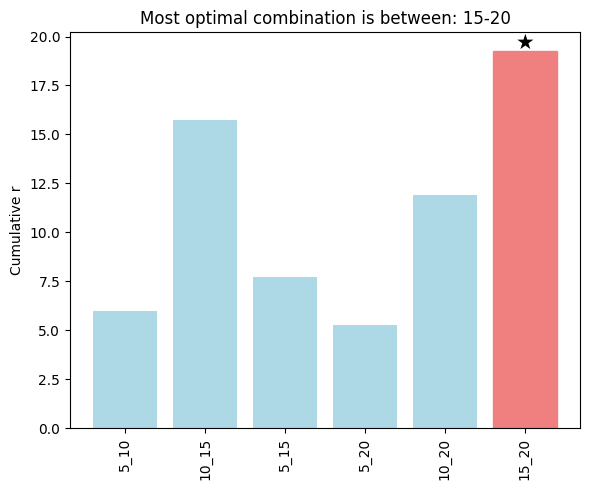

In [ ]:
if __name__ == "__main__":
    min_value = int(input("Enter the minimum value for the range: "))
    max_value = int(input("Enter the maximum value for the range: "))
    alpha = float(input("Enter the significance level (default is 0.05): ") or "0.05")

    # Explanation and prompt for anatomical overlap threshold
    print("\nThe anatomical overlap threshold determines how close the peak voxels of two components should be "
          "to consider them as overlapping. A smaller value means they must be very close, while a larger value "
          "allows for greater distances. The value is in voxels.")
    distance_threshold = int(input("Enter the anatomical overlap threshold (default is 5 voxels): ") or "5")

    n_low_range = range(min_value, max_value + 1, 5)
    n_high_range = n_low_range

    adhd_dataset = datasets.fetch_adhd(n_subjects=1)

    best_values, results = optimize_components(n_low_range, n_high_range, adhd_dataset.func, alpha, distance_threshold)
    print(f"Optimal N-low: {best_values['n_low']}, N-high: {best_values['n_high']}, with cumulative r: {best_values['cumulative_r']:.3f}")
    plot_results(results, f"{best_values['n_low']}-{best_values['n_high']}", min_value, max_value)

## Hierarchical Clustering Between High- vs. Low-Order Component Dictionary Learning

In [22]:
# @title ComponentCorrelation class

import numpy as np
from nilearn import datasets, decomposition
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib


class ComponentCorrelation:
    def __init__(self, n_low_order, n_high_order, memory_level=2, cache_dir="nilearn_cache"):
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order
        self.cache_dir = cache_dir
        self.memory_level =  memory_level

    def _fetch_data(self):
        """Fetch sample functional data for testing."""
        dataset = datasets.fetch_adhd(n_subjects=1)
        self.func_filename = dataset.func

    def _perform_decomposition(self):
        options = {
            "random_state": 0,
            "memory": self.cache_dir,
            "memory_level": self.memory_level
        }

        dict_learn_low = decomposition.DictLearning(n_components=self.n_low_order, **options)
        dict_learn_high = decomposition.DictLearning(n_components=self.n_high_order, **options)

        self.components_img_low = dict_learn_low.fit_transform(self.func_filename)
        self.components_img_high = dict_learn_high.fit_transform(self.func_filename)

    def _get_peak_coordinates(self, component):
        """Get the coordinates of the peak (maximum value) of the component."""
        # If the component is a Nifti1Image, extract its data, else assume it's a numpy array
        data = component.get_data() if isinstance(component, nib.Nifti1Image) else component
        max_val_index = np.unravel_index(np.argmax(data), data.shape)
        return max_val_index


    def _anatomical_overlap(self, comp1, comp2):
        """Check if two components have peaks in a proximal location."""
        peak1 = self._get_peak_coordinates(comp1)
        peak2 = self._get_peak_coordinates(comp2)

        distance = np.linalg.norm(np.array(peak1) - np.array(peak2))

        distance_threshold = 5  # adjust this value as necessary (this is in voxels)
        return distance < distance_threshold

    def _compute_correlation_matrix(self):
        self.correlation_matrix = np.zeros((self.n_low_order, self.n_high_order))
        self.results = []

        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]

                if not self._anatomical_overlap(data_low, data_high):
                    continue

                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())

                self.results.append({
                    'Low_Order_Component': i,
                    'High_Order_Component': j,
                    'Pearson_r': correlation,
                    'p_value': p_value
                })
                self.correlation_matrix[i, j] = correlation

        # Handle invalid values
        self.correlation_matrix = np.nan_to_num(self.correlation_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    def _plot_heatmap(self):
        diverging_cmap = plt.cm.RdBu_r
        figsize = (10, 5)
        sns.clustermap(
            self.correlation_matrix,
            method="average",
            cmap=diverging_cmap,
            vmin=-1,
            vmax=1,
            annot=False,
            fmt=".2f",
            figsize=figsize
        )
        plt.show()

    def export_results_to_csv(self, filename="correlation_results.csv"):
        df = pd.DataFrame(self.results)
        df = df.sort_values(by='p_value')
        df.to_csv(filename, index=False)

    def visualize_component_correlation(self):
        self._fetch_data()
        self._perform_decomposition()
        self._compute_correlation_matrix()
        self._plot_heatmap()

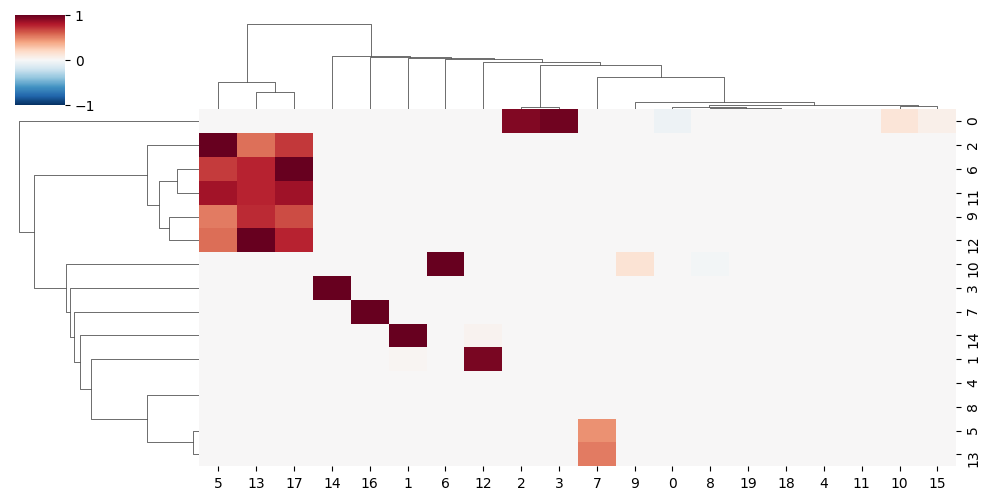

In [ ]:
if __name__ == "__main__":
    n_low_order = 15
    n_high_order = 20

    correlation_tool = ComponentCorrelation(n_low_order=n_low_order, n_high_order=n_high_order)
    correlation_tool.visualize_component_correlation()
    correlation_tool.export_results_to_csv()

## Anatomic Visualization of High- and Low-Order Component Dictionary Learning Decomposition


In [29]:
# @title Decomposition per subject
from nilearn import datasets, image, plotting
from nilearn.decomposition import DictLearning
from nilearn.image import concat_imgs

def apply_dictionary_learning_to_subject(func_file, n_components, fwhm, title_prefix):
    """Apply Dictionary Learning decomposition to a subject's fMRI data and visualize the components."""
    fmri_subject = image.smooth_img(func_file, fwhm=fwhm)
    dict_learn_subject = DictLearning(n_components=n_components, random_state=0)
    dict_learn_subject.fit(fmri_subject)

    components_img_subject = dict_learn_subject.components_img_

    # Visualize overall atlas and individual components
    plotting.plot_prob_atlas(components_img_subject, title=f'{title_prefix} Dictionary Learning maps')
    plotting.show()

    for j in range(n_components):
        component_img = image.index_img(components_img_subject, j)
        plotting.plot_stat_map(component_img, title=f'{title_prefix} Component {j}')
        plotting.show()

def apply_dictionary_learning_to_all(func_filenames, n_components, title_prefix):
    """Apply Dictionary Learning decomposition to concatenated fMRI data and visualize averaged components."""
    all_fmri = concat_imgs(func_filenames)

    dict_learn_all = DictLearning(n_components=n_components, random_state=0)
    dict_learn_all.fit(all_fmri)
    components_img_all = dict_learn_all.components_img_

    plotting.plot_prob_atlas(components_img_all, title=f'{title_prefix} Dictionary Learning maps')
    plotting.show()

In [ ]:
if __name__ == "__main__":
    # Fetch the ADHD200 resting-state fMRI dataset
    n_subjects = 1
    adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
    func_filenames = adhd_dataset.func

    # Parameters
    low_order_components = 15
    high_order_components = 20
    fwhm = 6

    # Apply Dictionary Learning and visualize results for each subject
    for i, func_file in enumerate(func_filenames):
        title_prefix = f'Subject {i} - Low Order'
        apply_dictionary_learning_to_subject(func_file, low_order_components, fwhm, title_prefix)

        title_prefix = f'Subject {i} - High Order'
        apply_dictionary_learning_to_subject(func_file, high_order_components, fwhm, title_prefix)

    # Apply Dictionary Learning and visualize results for concatenated data
    apply_dictionary_learning_to_all(func_filenames, low_order_components, "All Subjects - Low Order")
    apply_dictionary_learning_to_all(func_filenames, high_order_components, "All Subjects - High Order")

# Testing

/usr/local/lib/python3.10/dist-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contour

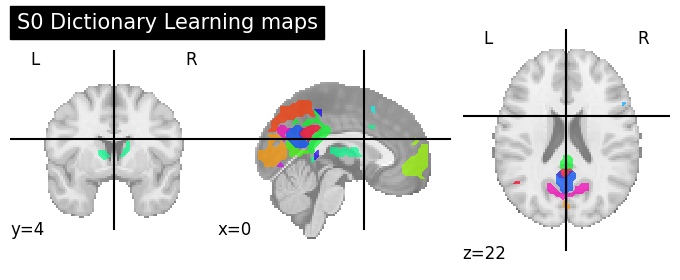

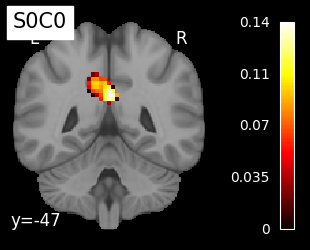

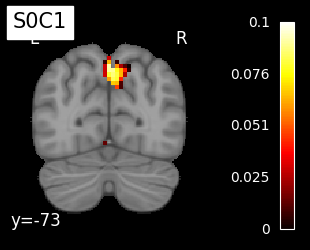

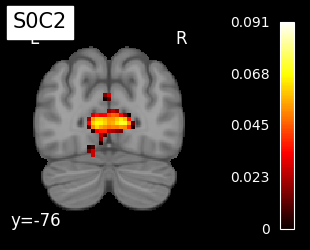

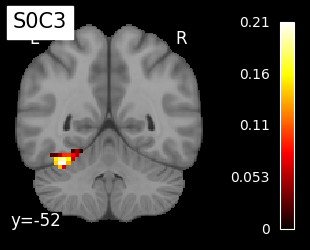

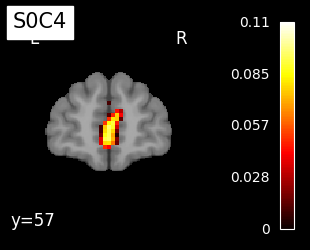

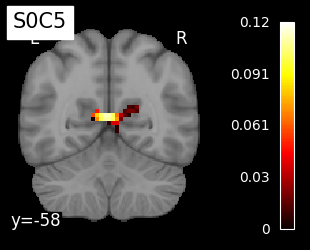

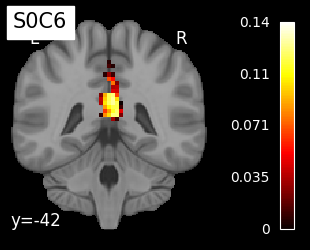

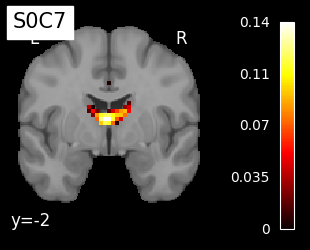

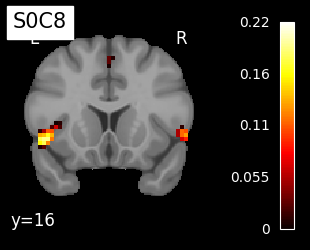

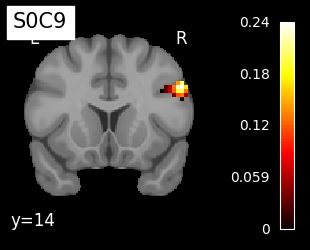

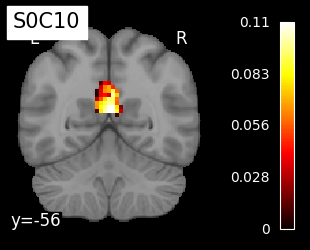

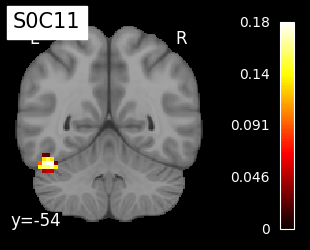

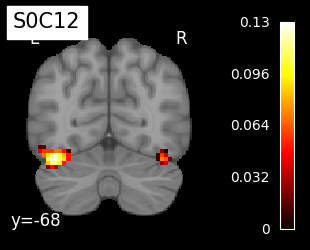

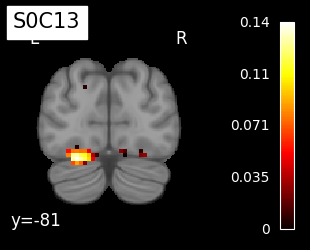

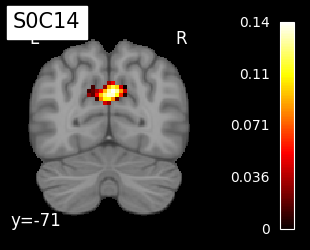

/usr/local/lib/python3.10/dist-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: linewidths is ignored by contour

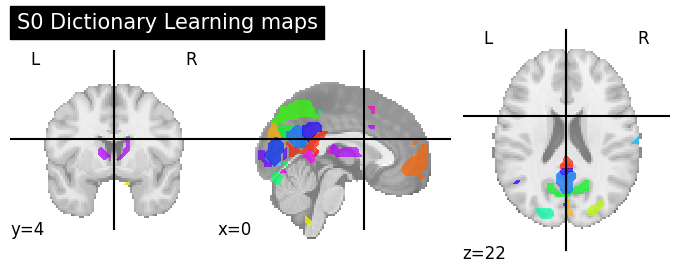

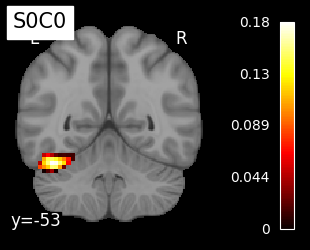

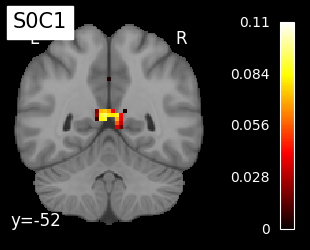

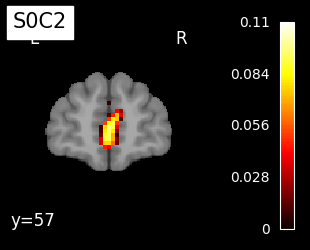

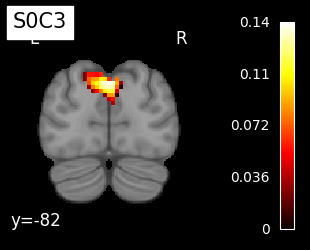

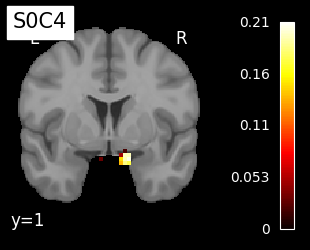

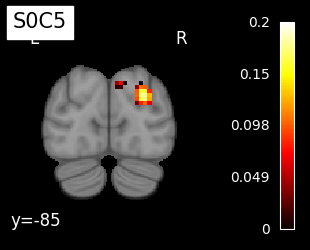

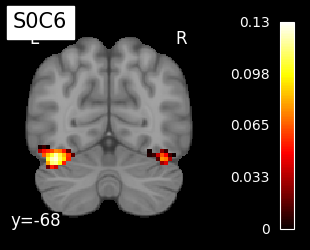

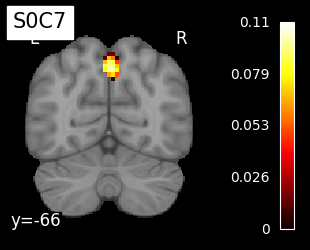

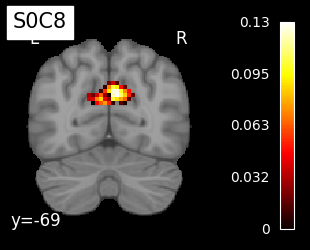

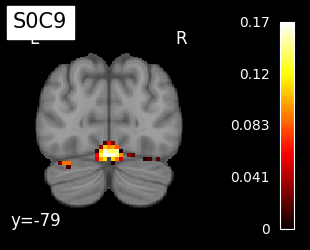

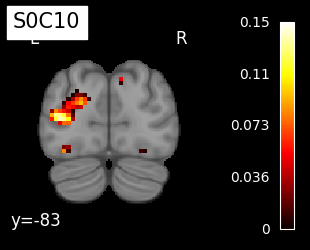

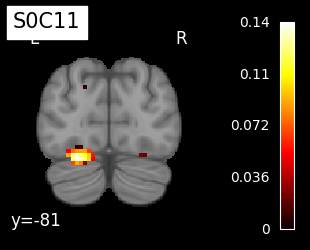

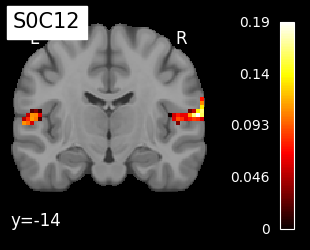

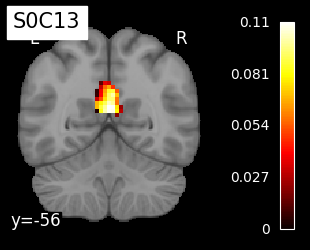

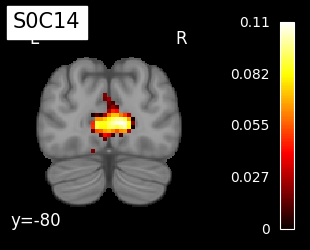

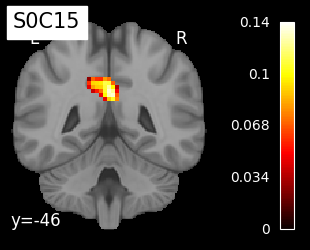

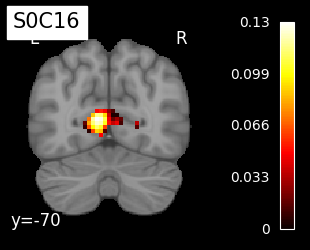

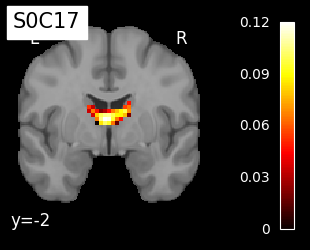

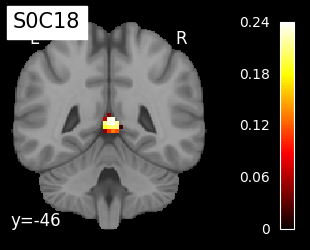

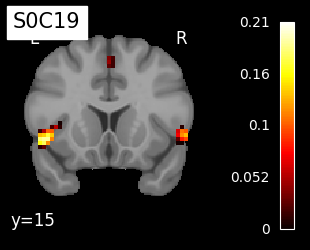

In [27]:
from nilearn import datasets, image, plotting
from nilearn.decomposition import DictLearning
from nilearn.image import concat_imgs

# Get the MNI152 template
bg_img = datasets.load_mni152_template()

def apply_dictionary_learning_to_subject(func_file, n_components, fwhm, subject_index):
    """Apply Dictionary Learning decomposition to a subject's fMRI data and visualize the components."""
    fmri_subject = image.smooth_img(func_file, fwhm=fwhm)
    dict_learn_subject = DictLearning(n_components=n_components, random_state=0)
    dict_learn_subject.fit(fmri_subject)

    components_img_subject = dict_learn_subject.components_img_

    # Visualize overall atlas and individual components
    title_atlas = f'S{subject_index} Dictionary Learning maps'
    plotting.plot_prob_atlas(components_img_subject, title=title_atlas)
    plotting.show()

    for j in range(n_components):
        component_img = image.index_img(components_img_subject, j)

        # Get the y-coordinate of the center of mass for the component
        y_coord = plotting.find_xyz_cut_coords(component_img)[1]

        # Plot the coronal view for the component with the desired title format
        title_component = f'S{subject_index}C{j}'
        plotting.plot_stat_map(component_img, bg_img=bg_img, cut_coords=[y_coord], display_mode='y', title=title_component, colorbar=True)

        plotting.show()

if __name__ == "__main__":
    # Fetch the ADHD200 resting-state fMRI dataset
    n_subjects = 1
    adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
    func_filenames = adhd_dataset.func

    # Parameters
    low_order_components = 15
    high_order_components = 20
    fwhm = 6

    # Apply Dictionary Learning and visualize results for each subject
    for i, func_file in enumerate(func_filenames):
        apply_dictionary_learning_to_subject(func_file, low_order_components, fwhm, i)
        apply_dictionary_learning_to_subject(func_file, high_order_components, fwhm, i)


In [ ]:
# @title ComponentCorrelation class W/O anatomic proximity

import numpy as np
from nilearn import datasets, decomposition
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib


class ComponentCorrelation:
    def __init__(self, n_low_order, n_high_order, memory_level=2, cache_dir="nilearn_cache"):
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order
        self.cache_dir = cache_dir
        self.memory_level =  memory_level

    def _fetch_data(self):
        """Fetch sample functional data for testing."""
        dataset = datasets.fetch_adhd(n_subjects=1)
        self.func_filename = dataset.func

    def _perform_decomposition(self):
        options = {
            "random_state": 0,
            "memory": self.cache_dir,
            "memory_level": self.memory_level
        }

        dict_learn_low = decomposition.DictLearning(n_components=self.n_low_order, **options)
        dict_learn_high = decomposition.DictLearning(n_components=self.n_high_order, **options)

        self.components_img_low = dict_learn_low.fit_transform(self.func_filename)
        self.components_img_high = dict_learn_high.fit_transform(self.func_filename)


    def _compute_correlation_matrix(self):
        self.correlation_matrix = np.zeros((self.n_low_order, self.n_high_order))
        self.results = []

        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]

                # if not self._anatomical_overlap(data_low, data_high):
                #     continue

                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())

                self.results.append({
                    'Low_Order_Component': i,
                    'High_Order_Component': j,
                    'Pearson_r': correlation,
                    'p_value': p_value
                })
                self.correlation_matrix[i, j] = correlation

        # Handle invalid values
        self.correlation_matrix = np.nan_to_num(self.correlation_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    def _plot_heatmap(self):
        diverging_cmap = plt.cm.RdBu_r
        figsize = (10, 5)
        sns.clustermap(
            self.correlation_matrix,
            method="average",
            cmap=diverging_cmap,
            vmin=-1,
            vmax=1,
            annot=False,
            fmt=".2f",
            figsize=figsize
        )
        plt.show()

    def export_results_to_csv(self, filename="correlation_results.csv"):
        df = pd.DataFrame(self.results)
        df = df.sort_values(by='p_value')
        df.to_csv(filename, index=False)

    def visualize_component_correlation(self):
        self._fetch_data()
        self._perform_decomposition()
        self._compute_correlation_matrix()
        self._plot_heatmap()

if __name__ == "__main__":
    n_low_order = 15
    n_high_order = 20

    correlation_tool = ComponentCorrelation(n_low_order=n_low_order, n_high_order=n_high_order)
    correlation_tool.visualize_component_correlation()
    correlation_tool.export_results_to_csv()

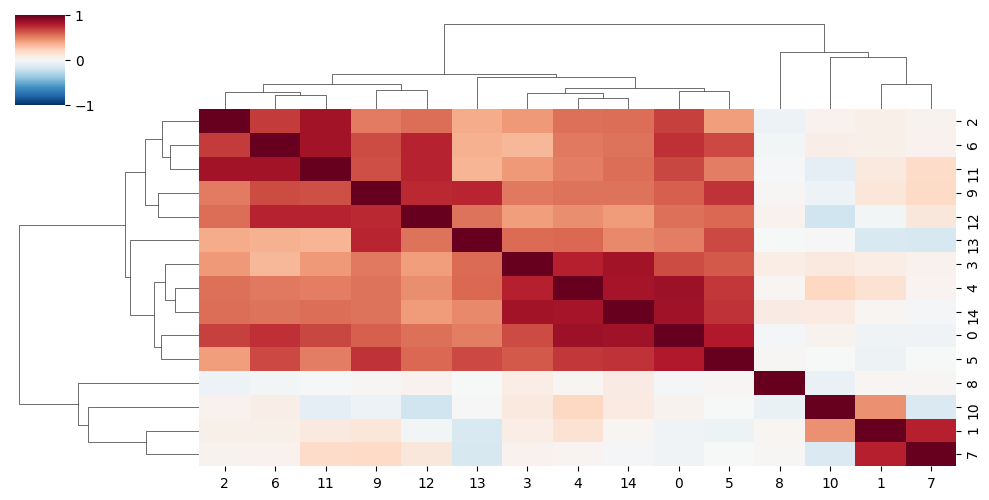

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


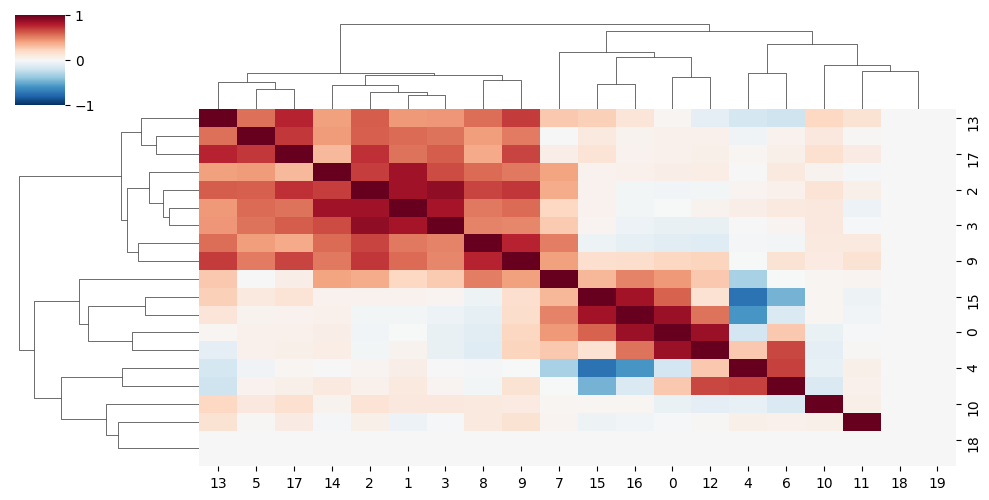

In [34]:
# @title ComponentCorrelation class W/O anatomic proximity

import numpy as np
from nilearn import datasets, decomposition
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib


class ComponentCorrelation:
    def __init__(self, n_low_order, n_high_order, memory_level=2, cache_dir="nilearn_cache"):
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order
        self.cache_dir = cache_dir
        self.memory_level =  memory_level

    def _fetch_data(self):
        """Fetch sample functional data for testing."""
        dataset = datasets.fetch_adhd(n_subjects=1)
        self.func_filename = dataset.func

    def _perform_decomposition(self):
        options = {
            "random_state": 0,
            "memory": self.cache_dir,
            "memory_level": self.memory_level
        }

        dict_learn_low = decomposition.DictLearning(n_components=self.n_low_order, **options)
        dict_learn_high = decomposition.DictLearning(n_components=self.n_high_order, **options)

        self.components_img_low = dict_learn_low.fit_transform(self.func_filename)
        self.components_img_high = dict_learn_high.fit_transform(self.func_filename)

    def _compute_correlation_matrix_for_low(self):
        self.correlation_matrix_low = np.zeros((self.n_low_order, self.n_low_order))
        self.results_low = []

        for i in range(self.n_low_order):
            for j in range(self.n_low_order):
                data_low_i = self.components_img_low[0][..., i]
                data_low_j = self.components_img_low[0][..., j]

                correlation, p_value = pearsonr(data_low_i.ravel(), data_low_j.ravel())

                self.results_low.append({
                    'Low_Order_Component_1': i,
                    'Low_Order_Component_2': j,
                    'Pearson_r': correlation,
                    'p_value': p_value
                })
                self.correlation_matrix_low[i, j] = correlation

        # Handle invalid values
        self.correlation_matrix_low = np.nan_to_num(self.correlation_matrix_low, nan=0.0, posinf=0.0, neginf=0.0)

    def _compute_correlation_matrix_for_high(self):
        self.correlation_matrix_high = np.zeros((self.n_high_order, self.n_high_order))
        self.results_high = []

        for i in range(self.n_high_order):
            for j in range(self.n_high_order):
                data_high_i = self.components_img_high[0][..., i]
                data_high_j = self.components_img_high[0][..., j]

                correlation, p_value = pearsonr(data_high_i.ravel(), data_high_j.ravel())

                self.results_high.append({
                    'High_Order_Component_1': i,
                    'High_Order_Component_2': j,
                    'Pearson_r': correlation,
                    'p_value': p_value
                })
                self.correlation_matrix_high[i, j] = correlation

        # Handle invalid values
        self.correlation_matrix_high = np.nan_to_num(self.correlation_matrix_high, nan=0.0, posinf=0.0, neginf=0.0)

    def _plot_heatmap(self, order='low'):
        diverging_cmap = plt.cm.RdBu_r
        figsize = (10, 5)

        if order == 'low':
            sns.clustermap(
                self.correlation_matrix_low,
                method="average",
                cmap=diverging_cmap,
                vmin=-1,
                vmax=1,
                annot=False,
                fmt=".2f",
                figsize=figsize
            )
        elif order == 'high':
            sns.clustermap(
                self.correlation_matrix_high,
                method="average",
                cmap=diverging_cmap,
                vmin=-1,
                vmax=1,
                annot=False,
                fmt=".2f",
                figsize=figsize
            )
        plt.show()


    def export_results_to_csv(self, order='both', filename="correlation_results.csv"):
        if order == 'low':
            df = pd.DataFrame(self.results_low)
        elif order == 'high':
            df = pd.DataFrame(self.results_high)
        elif order == 'both':
            df_low = pd.DataFrame(self.results_low)
            df_high = pd.DataFrame(self.results_high)
            df = pd.concat([df_low, df_high], ignore_index=True)
        else:
            raise ValueError("Invalid order value. Choose from 'low', 'high', or 'both'.")

        df = df.sort_values(by='p_value')
        df.to_csv(filename, index=False)


    def visualize_component_correlation(self):
        self._fetch_data()
        self._perform_decomposition()

        self._compute_correlation_matrix_for_low()
        self._plot_heatmap(order='low')

        self._compute_correlation_matrix_for_high()
        self._plot_heatmap(order='high')


if __name__ == "__main__":
    n_low_order = 15
    n_high_order = 20

    correlation_tool = ComponentCorrelation(n_low_order=n_low_order, n_high_order=n_high_order)
    correlation_tool.visualize_component_correlation()
    correlation_tool.export_results_to_csv()

/usr/local/lib/python3.10/dist-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)
<ipython-input-39-69d8c44c70d6>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


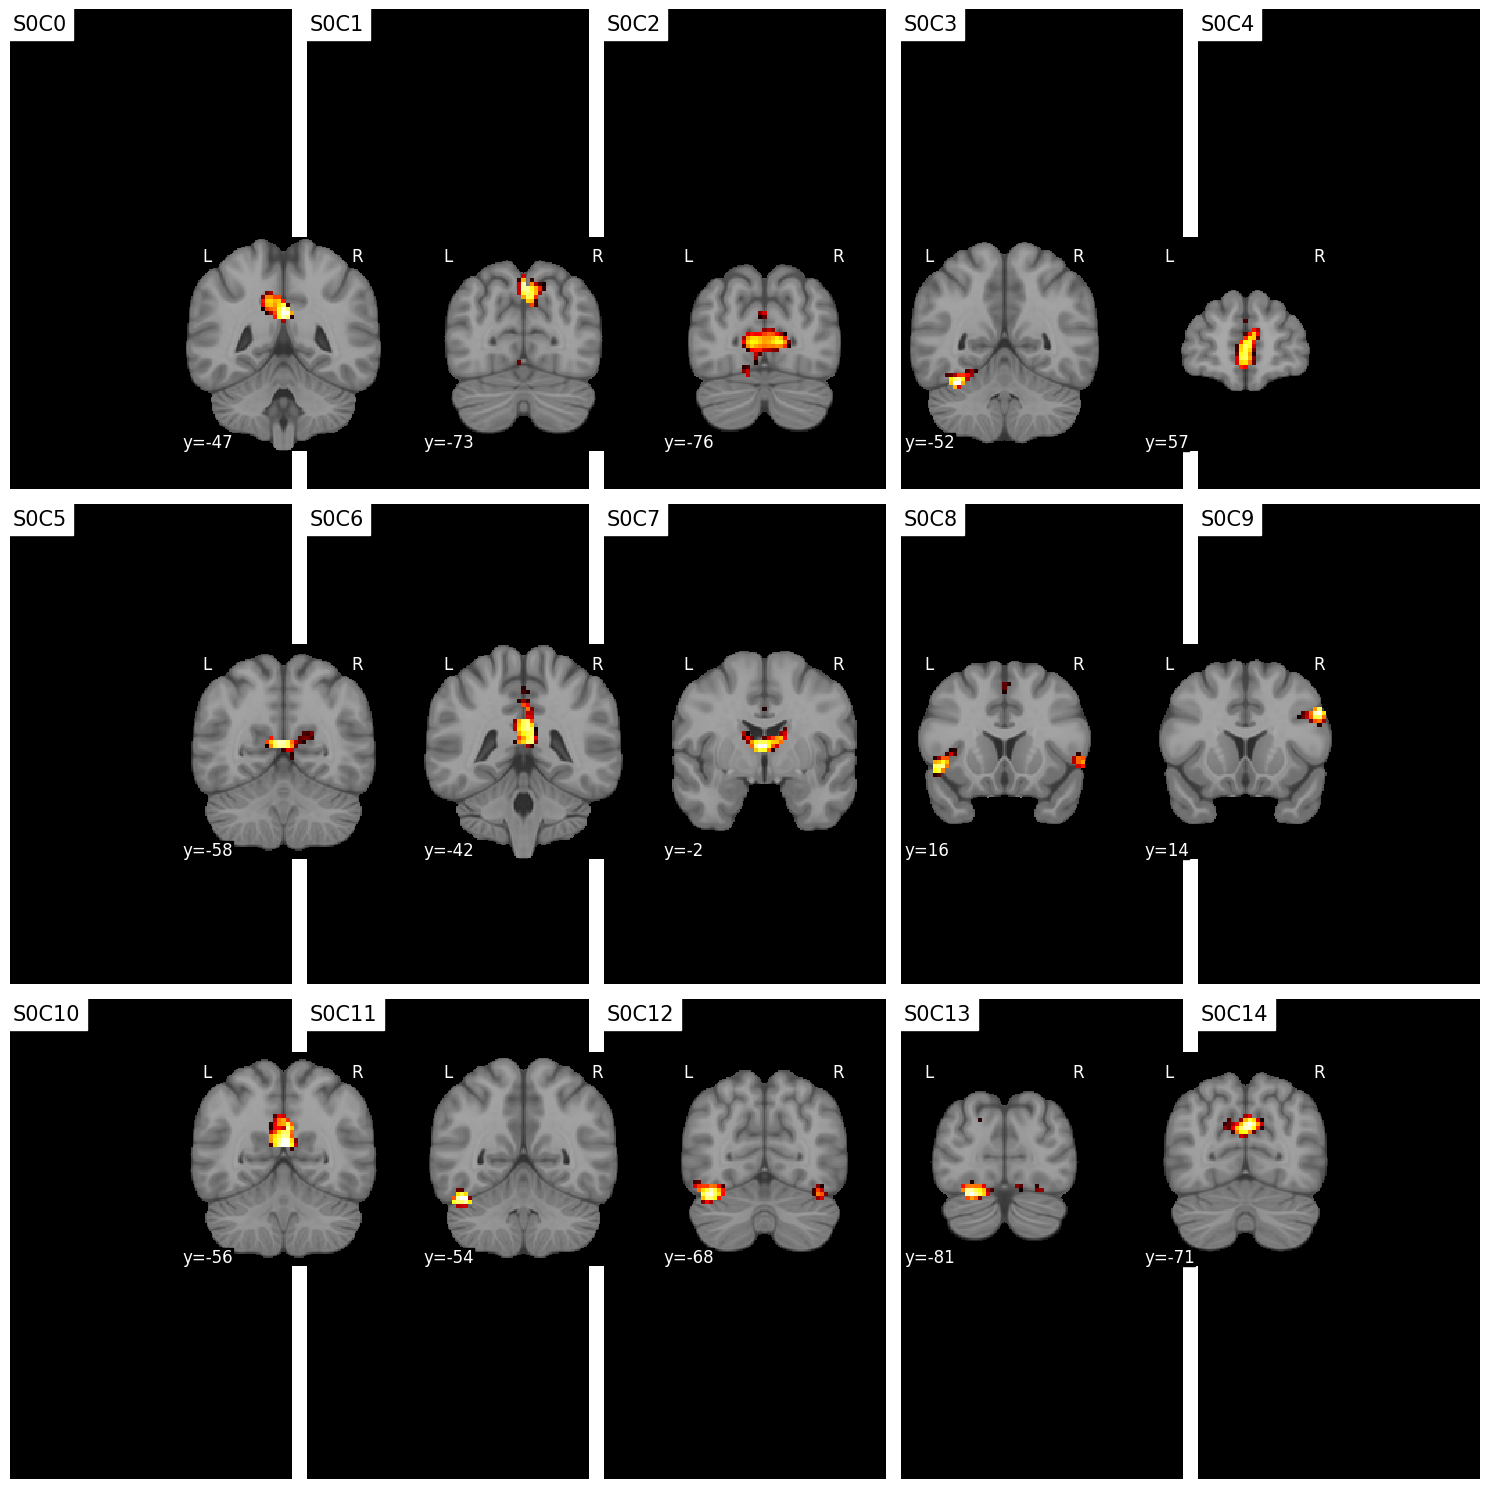

/usr/local/lib/python3.10/dist-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)
<ipython-input-39-69d8c44c70d6>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


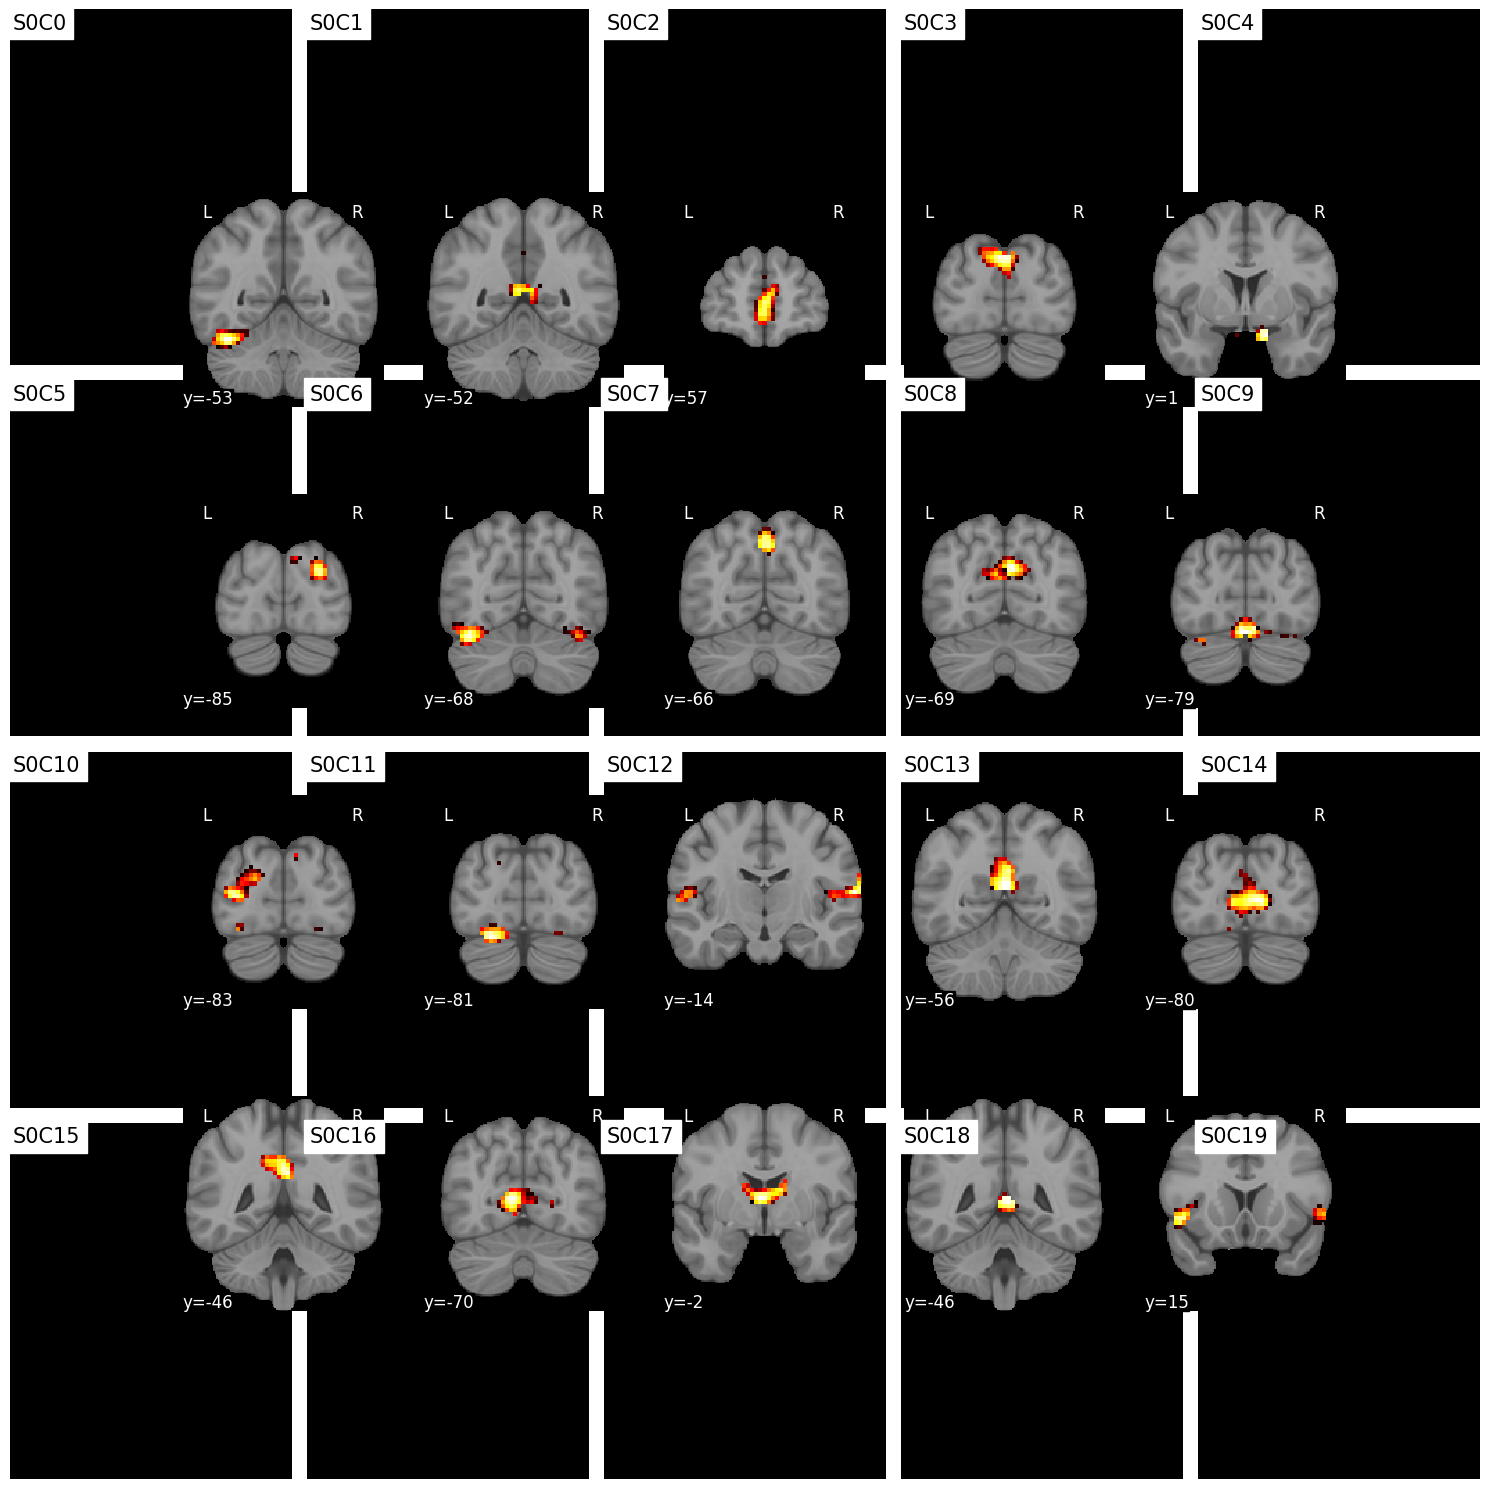

In [39]:
import matplotlib.pyplot as plt

def apply_dictionary_learning_to_subject(func_file, n_components, fwhm, subject_index):
    """Apply Dictionary Learning decomposition to a subject's fMRI data and visualize the components."""
    fmri_subject = image.smooth_img(func_file, fwhm=fwhm)
    dict_learn_subject = DictLearning(n_components=n_components, random_state=0)
    dict_learn_subject.fit(fmri_subject)

    components_img_subject = dict_learn_subject.components_img_

    # Create a subplot matrix for visualization
    n_cols = 5  # You can adjust this as per your preference
    n_rows = int(np.ceil(n_components / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

    for j in range(n_components):
        ax = axes.ravel()[j]
        component_img = image.index_img(components_img_subject, j)

        # Get the y-coordinate of the center of mass for the component
        y_coord = plotting.find_xyz_cut_coords(component_img)[1]

        # Plot the coronal view for the component with the desired title format
        title_component = f'S{subject_index}C{j}'
        plotting.plot_stat_map(component_img, bg_img=bg_img, cut_coords=[y_coord], display_mode='y', title=title_component, axes=ax, colorbar=False)

    # Turn off any remaining axes that don't have content
    for j in range(n_components, n_cols * n_rows):
        axes.ravel()[j].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Fetch the ADHD200 resting-state fMRI dataset
    n_subjects = 1
    adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
    func_filenames = adhd_dataset.func

    # Parameters
    low_order_components = 15
    high_order_components = 20
    fwhm = 6

    # Apply Dictionary Learning and visualize results for each subject
    for i, func_file in enumerate(func_filenames):
        apply_dictionary_learning_to_subject(func_file, low_order_components, fwhm, i)
        apply_dictionary_learning_to_subject(func_file, high_order_components, fwhm, i)



/usr/local/lib/python3.10/dist-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)
<ipython-input-70-67d4a68db074>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


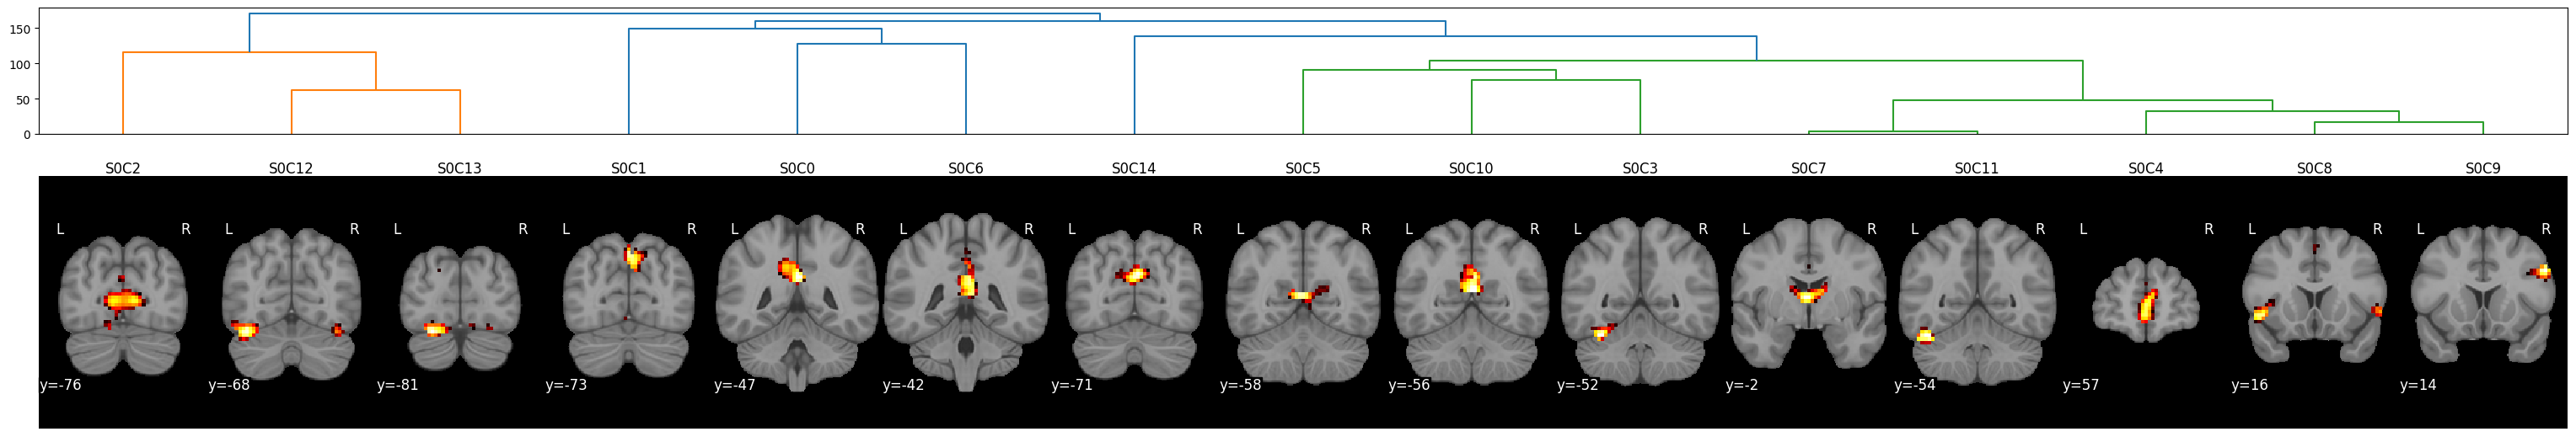

/usr/local/lib/python3.10/dist-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)
<ipython-input-70-67d4a68db074>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


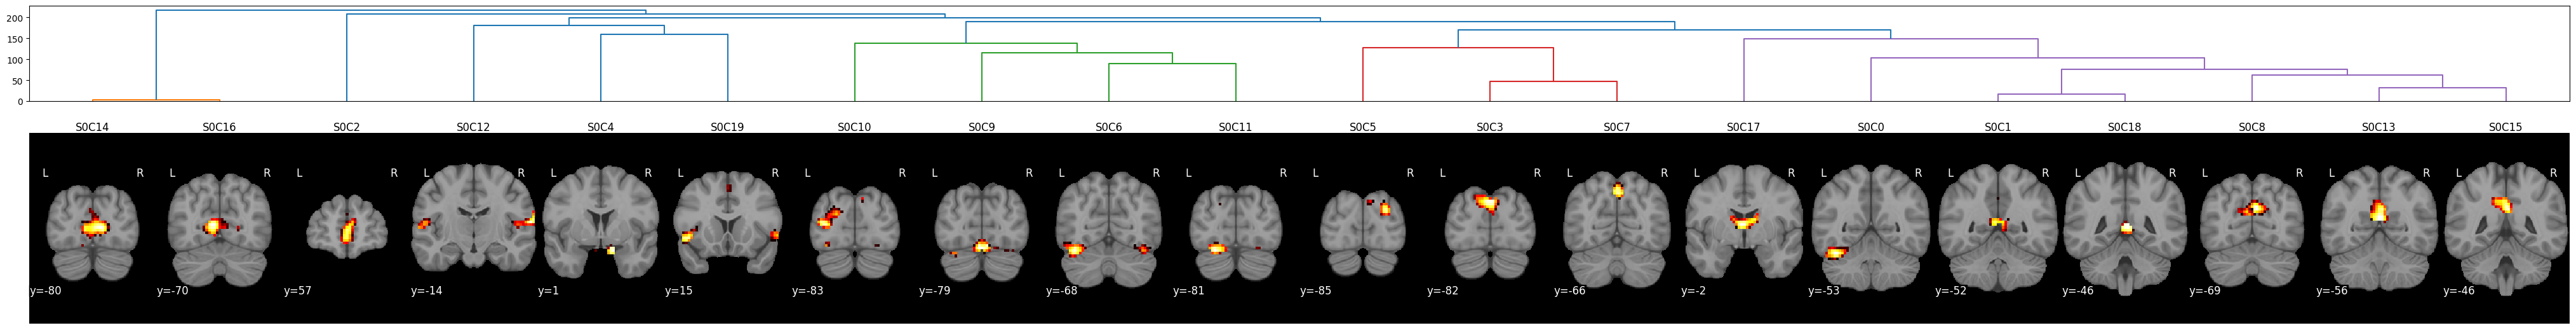

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist

def scale_dendrogram(Z, scale_factor=2.5, power=3):
    """Scale the distances in the linkage matrix for dendrogram display with nonlinear scaling."""
    Z_scaled = Z.copy()
    n = Z.shape[0] + 1  # Initial number of single clusters
    for i, row in enumerate(Z_scaled):
        depth = (np.log(i + 1) + 1) ** power
        Z_scaled[i, 2] = row[2] * scale_factor * depth
    return Z_scaled

def apply_dictionary_learning_to_subject(func_file, n_components, fwhm, subject_index):
    """Apply Dictionary Learning decomposition to a subject's fMRI data and visualize the components."""
    fmri_subject = image.smooth_img(func_file, fwhm=fwhm)
    dict_learn_subject = DictLearning(n_components=n_components, random_state=0)
    dict_learn_subject.fit(fmri_subject)

    components_img_subject = dict_learn_subject.components_img_

    # Compute the correlation matrix
    correlation_matrix = np.zeros((n_components, n_components))
    for i in range(n_components):
        for j in range(n_components):
            data_i = components_img_subject.get_fdata()[..., i].ravel()
            data_j = components_img_subject.get_fdata()[..., j].ravel()

            correlation, _ = pearsonr(data_i, data_j)
            correlation_matrix[i, j] = correlation

    # Use linkage to get hierarchical cluster and then scale it
    Z = linkage(pdist(correlation_matrix), method="average")
    Z_scaled = scale_dendrogram(Z)
    ordered_indices = leaves_list(Z_scaled)

    # Create a custom grid layout
    fig = plt.figure(figsize=(2 * n_components, 5))
    dendro_ax = fig.add_axes([0, 0.7, 1, 0.3])
    component_axes = [fig.add_axes([j * (1.0/n_components), 0, 1.0/n_components, 0.6]) for j in range(n_components)]

    # Plot the scaled dendrogram
    dendrogram(Z_scaled, ax=dendro_ax, orientation='top', no_labels=True, count_sort='ascending',
              p=1000, truncate_mode=None, color_threshold=None, show_contracted=False)

    dendro_ax.set(xticks=[], xticklabels=[], ylabel='')

    # Plot components in the order produced by the hierarchical clustering
    for j, idx in enumerate(ordered_indices):
        component_img = image.index_img(components_img_subject, idx)
        y_coord = plotting.find_xyz_cut_coords(component_img)[1]
        plotting.plot_stat_map(component_img, bg_img=bg_img, cut_coords=[y_coord], display_mode='y', axes=component_axes[j], colorbar=False)

        title_component = f'S{subject_index}C{idx}'
        component_axes[j].set_title(title_component, va='center')

    plt.tight_layout()
    plt.show()

# Rest of your code ...

if __name__ == "__main__":
    # Fetch the ADHD200 resting-state fMRI dataset
    n_subjects = 1
    adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
    func_filenames = adhd_dataset.func

    # Parameters
    low_order_components = 15
    high_order_components = 20
    fwhm = 6

    # Apply Dictionary Learning and visualize results for each subject
    for i, func_file in enumerate(func_filenames):
        apply_dictionary_learning_to_subject(func_file, low_order_components, fwhm, i)
        apply_dictionary_learning_to_subject(func_file, high_order_components, fwhm, i)
